
# Comparing Classifiers on Portuguese Bank Marketing Dataset

**Models:** K-Nearest Neighbors, Logistic Regression, Decision Tree, Support Vector Machine  
**Dataset:** `bank-additional-full.csv` (UCI Bank Marketing, Portuguese bank telephone campaigns)  
**Goal:** Predict whether a client will subscribe to a term deposit (**target:** `y`) and compare model performance.



## 1. Business Understanding

Marketing teams need to **prioritize who to call** to maximize subscriptions while minimizing wasted calls.  
We will build pre-contact models (so we **exclude `duration`** to avoid leakage) and compare classifiers using **AUC** as the primary metric. We also include **Lift curves** to align with marketing use-cases.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Data Understanding & Preparation

In [8]:
# Load dataset
df = pd.read_csv("/content/sample_data/bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
# Quick Overview
display(df.sample(15))
print("Shape:", df.shape)
print("Columns:", list(df.columns))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32884,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
3169,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
32206,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no
9403,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
14020,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
17201,58,retired,married,professional.course,no,yes,yes,cellular,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
879,48,services,married,high.school,unknown,yes,no,telephone,may,wed,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
23757,51,admin.,divorced,university.degree,unknown,yes,no,cellular,aug,thu,...,7,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
10821,24,entrepreneur,married,university.degree,no,yes,yes,telephone,jun,wed,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
14355,36,technician,divorced,professional.course,no,yes,yes,cellular,jul,mon,...,4,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


Shape: (41188, 21)
Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


In [10]:
#Clean up column names
df.columns = (
    df.columns.str.strip()                     # remove spaces
              .str.lower()                     # lowercase
              .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)  # non-alphanumeric -> _
              .str.replace(r'_+', '_', regex=True)              # collapse multiple underscores
              .str.strip('_')                   # remove underscores from start/end
)

# Check the result
print(df.columns.tolist())

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [11]:
# Define target column
target_col = "y"

# Map 'yes'/'no' to 1/0
y = df[target_col].map({"yes": 1, "no": 0})

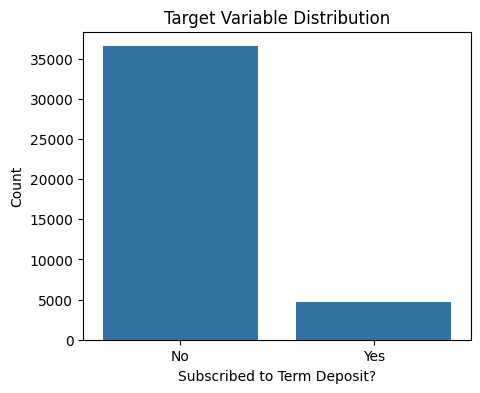

In [12]:
#Target variable distribution
plt.figure(figsize=(5,4))
sns.countplot(x=y.map({1: "Yes", 0: "No"}))
plt.title("Target Variable Distribution")
plt.xlabel("Subscribed to Term Deposit?")
plt.ylabel("Count")
plt.show()

In [13]:
# Recreate X and y
target_col = "y"
leakage_cols = ["duration"] if "duration" in df.columns else []
X = df.drop(columns=[target_col] + leakage_cols)
y = df[target_col].map({"yes": 1, "no": 0})

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

/tmp/ipython-input-1800809475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[target_col] = y.map({1: "Yes", 0: "No"})


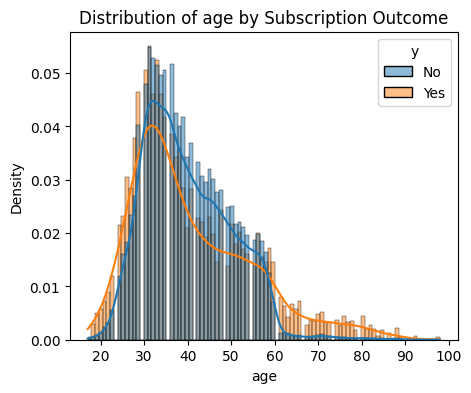

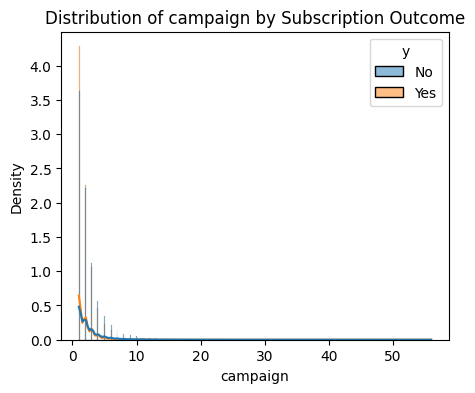

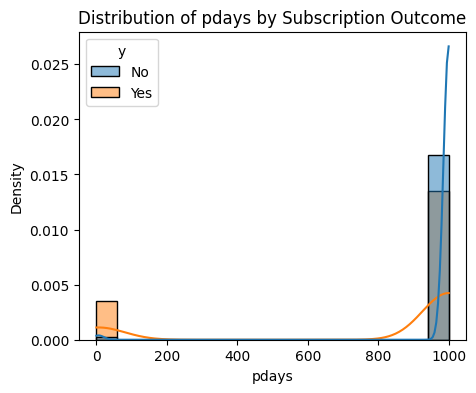

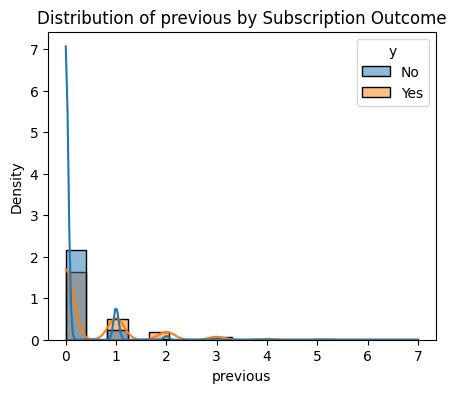

In [14]:
#Numeric feature distributions
numeric_sample = numeric_cols[:4]
df_numeric = X[numeric_sample]
df_numeric[target_col] = y.map({1: "Yes", 0: "No"})

for col in numeric_sample:
    plt.figure(figsize=(5,4))
    sns.histplot(data=df_numeric, x=col, hue=target_col, kde=True, stat="density", common_norm=False)
    plt.title(f"Distribution of {col} by Subscription Outcome")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()


In [15]:
# Identify target column
target_col = "y"

# Columns known to be post-contact or leakage-prone: 'duration'
leakage_cols = ["duration"] if "duration" in df.columns else []

# Separate features and target
X = df.drop(columns=[target_col] + leakage_cols)
y = df[target_col].map({"yes":1, "no":0})  # binary 1/0

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['age', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [16]:
# Replace 'unknown' with np.nan then impute by most frequent
for c in categorical_cols:
    X[c] = X[c].replace("unknown", np.nan)

# Drop rows with NaN in the target variable y
nan_rows = y.isna()
if nan_rows.any():
  print(f"Dropping {nan_rows.sum()} rows with NaN in target variable 'y'.")
X = X[y.notna()]
y = y[y.notna()]

In [17]:
# Preprocessing: fill in missing values in numeric columns
numeric_transformer = Pipeline(steps=[
    ("imputer", __import__("sklearn").impute.SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [18]:
#Fill missing values with the most common category
categorical_transformer = Pipeline(steps=[
    ("imputer", __import__("sklearn").impute.SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

/tmp/ipython-input-3482395637.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical[target_col] = y.map({1: "Yes", 0: "No"})


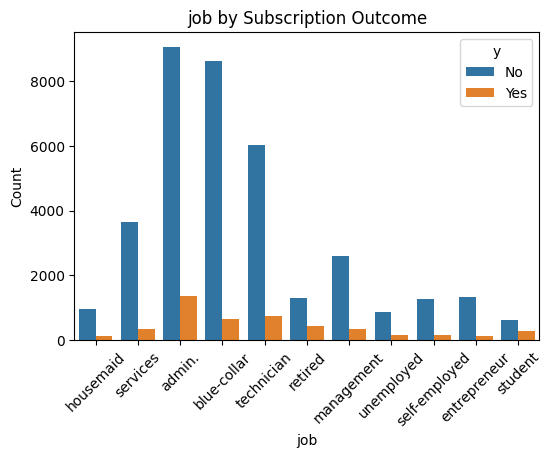

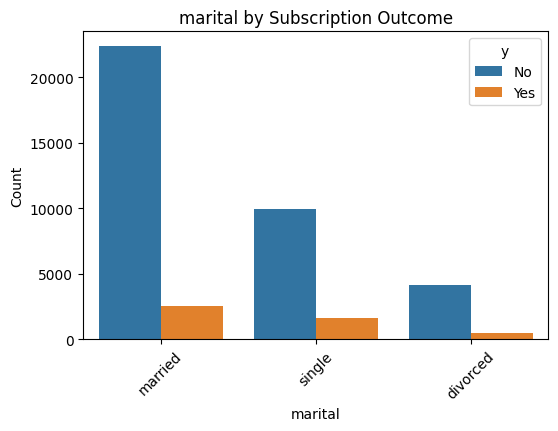

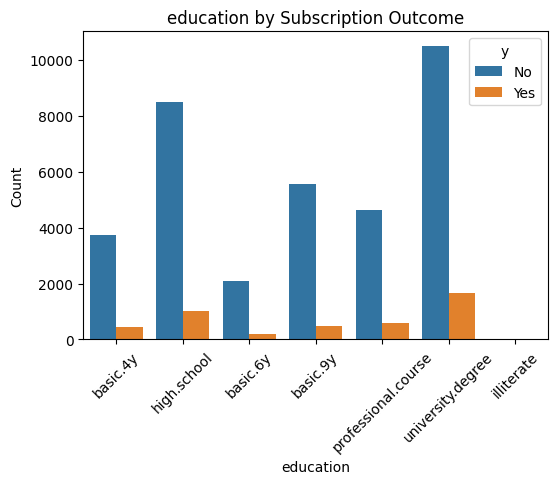

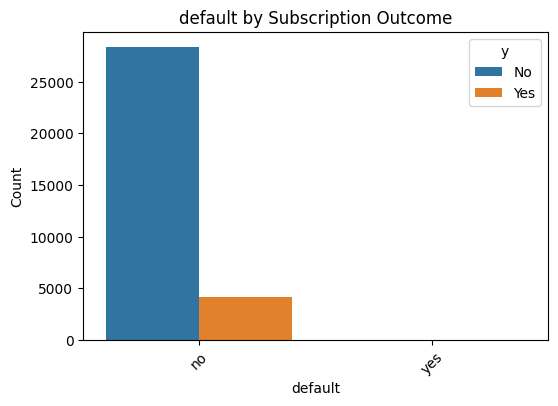

In [19]:
#Categorical feature counts
categorical_sample = categorical_cols[:4]  # first 4 categorical features
df_categorical = X[categorical_sample]
df_categorical[target_col] = y.map({1: "Yes", 0: "No"})

for col in categorical_sample:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_categorical, x=col, hue=target_col)
    plt.title(f"{col} by Subscription Outcome")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()

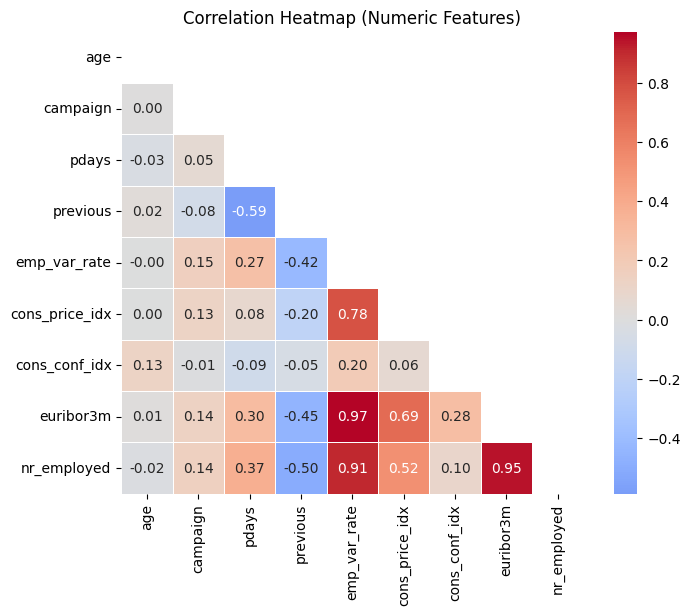

In [20]:
# Correlation heatmap (numeric only) - unique values only
plt.figure(figsize=(8,6))
corr = X[numeric_cols].corr()

# Mask the upper triangle to remove duplicates
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    annot=True,      # show numbers
    fmt=".2f",       # two decimal places
    square=True,
    linewidths=.5    # thin lines between cells
)

plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [21]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [22]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, stratify=y, random_state=RANDOM_STATE
)

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(y
 0    0.887355
 1    0.112645
 Name: proportion, dtype: float64,
 y
 0    0.887327
 1    0.112673
 Name: proportion, dtype: float64)

## 3. Modeling

In [23]:
# KNN Pipeline
knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", KNeighborsClassifier())
])

# KNN hyperparameter grid
knn_param_grid = {
    "clf__n_neighbors": [5, 11, 21],      # number of neighbors
    "clf__weights": ["uniform", "distance"],  # weight strategy
    "clf__p": [1, 2]                       # distance metric: 1=Manhattan, 2=Euclidean
}

In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)

# Best model from grid search
best_knn = knn_grid.best_estimator_

# Predictions
y_proba = best_knn.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [25]:
# Measure prediction speed
start_time = time.time()

y_pred = knn_grid.predict(X_test)  # Predictions
y_proba = knn_grid.predict_proba(X_test)[:, 1]  # Probabilities

end_time = time.time()
prediction_time = end_time - start_time

# Metrics
# Accuracy = (TP + TN) / total predictions
# Precision = TP / (TP + FP), Recall = TP / (TP + FN)
# Extract confusion matrix counts
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("=== KNN: Best Params ===")
print(knn_grid.best_params_)

print("\n=== KNN: Test Metrics ===")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1:              {f1:.4f}")
print(f"Confusion:       TP={tp} FP={fp} TN={tn} FN={fn}")
print(f"Prediction Time: {prediction_time:.6f} seconds")


=== KNN: Best Params ===
{'clf__n_neighbors': 21, 'clf__p': 1, 'clf__weights': 'uniform'}

=== KNN: Test Metrics ===
Accuracy:        0.9004
Precision:       0.6578
Recall:          0.2411
F1:              0.3529
Confusion:       TP=373 FP=194 TN=11989 FN=1174
Prediction Time: 53.995421 seconds


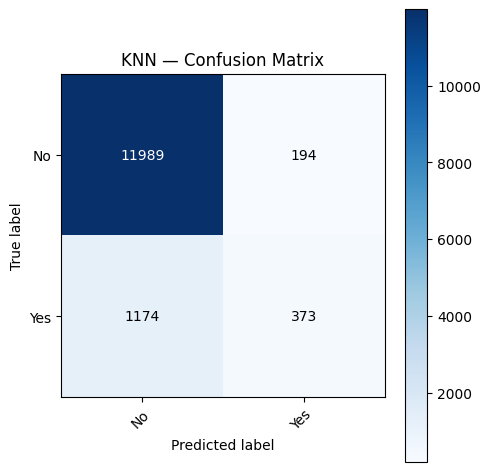

In [26]:
# Function to plot a confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Show all ticks and label them with class names
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names, yticklabels=class_names,
        ylabel='True label',
        xlabel='Predicted label',
        title=title
    )

    # Rotate the tick labels on x-axis
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Annotate cells with numbers
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Create confusion matrix from predictions
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plot_confusion_matrix(cm, class_names=["No", "Yes"], title="KNN — Confusion Matrix")

In [27]:
# Logistic Regression Pipeline
logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=200,
        class_weight="balanced",
        solver="liblinear"
    ))
])

# Logistic Regression hyperparameter grid
logreg_param_grid = {
    "clf__C": [0.1, 1.0, 10.0]  # inverse of regularization strength
}

In [28]:
# Perform GridSearchCV for Logistic Regression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
logreg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp_var_rate',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'euribor3m',
                                                                          'nr_employ...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=200,
                                                           solver='liblinear'))]),
             n_jobs=-1, param_grid={'clf__C': [0.1, 1.0, 10.0]},
             scoring='roc_auc', verbose=1)

In [29]:
# Fit on training data
logreg_grid.fit(X_train, y_train)

# Best Logistic Regression model
best_logreg = logreg_grid.best_estimator_

# Predictions
y_proba = best_logreg.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [30]:
# Measure prediction time
start_time = time.time()
y_pred = best_logreg.predict(X_test)
y_proba = best_logreg.predict_proba(X_test)[:, 1]
end_time = time.time()
prediction_time = end_time - start_time

# Metrics
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("=== Logistic Regression: Best Params ===")
print(logreg_grid.best_params_)

print("\n=== Logistic Regression: Test Metrics ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"Confusion: TP={tp} FP={fp} TN={tn} FN={fn}")
print(f"Prediction Time: {prediction_time:.6f} seconds")

=== Logistic Regression: Best Params ===
{'clf__C': 0.1}

=== Logistic Regression: Test Metrics ===
Accuracy:  0.8320
Precision: 0.3622
Recall:    0.6445
F1:        0.4637
Confusion: TP=997 FP=1756 TN=10427 FN=550
Prediction Time: 0.134595 seconds


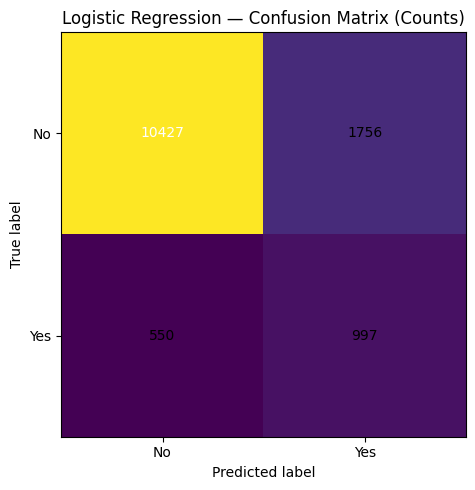

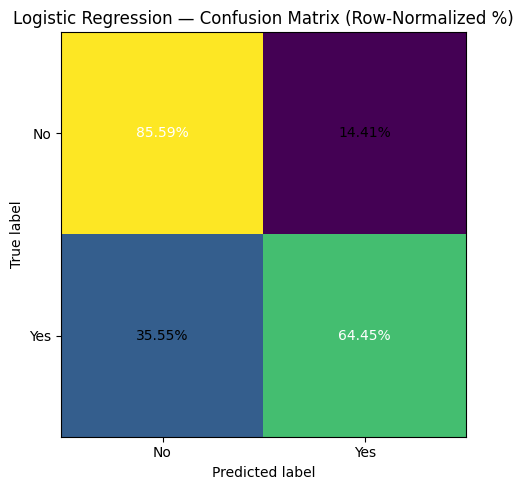

In [31]:
# Compute confusion matrices
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # row-normalized

classes = ["No", "Yes"]

def plot_cm(matrix, labels, title, fmt="{:d}"):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(matrix, interpolation="nearest")  # default colormap
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # annotate cells
    thresh = matrix.max() / 2.0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(
                j, i, fmt.format(matrix[i, j]),
                ha="center", va="center",
                color="white" if matrix[i, j] > thresh else "black"
            )
    fig.tight_layout()
    plt.show()

# 1) Raw counts
plot_cm(cm, classes, "Logistic Regression — Confusion Matrix (Counts)", fmt="{:d}")

# 2) Row-normalized percentages
plot_cm(cm_norm, classes, "Logistic Regression — Confusion Matrix (Row-Normalized %)", fmt="{:.2%}")

In [32]:
# Decision Tree Pipeline
from sklearn.tree import DecisionTreeClassifier
dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
])

In [33]:
# GridSearchCV for Decision Tree
dt_grid = GridSearchCV(
    estimator=dt_pipeline,
    param_grid={
        "clf__max_depth": [5, 10, 20, None],  # note the double underscores
        "clf__min_samples_leaf": [1, 5, 20]
    },
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [34]:
# Fit on training data
dt_grid.fit(X_train, y_train)

# Best model
best_dt = dt_grid.best_estimator_

# Measure prediction time
start_time = time.time()
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]
end_time = time.time()
prediction_time = end_time - start_time

Fitting 5 folds for each of 12 candidates, totalling 60 fits


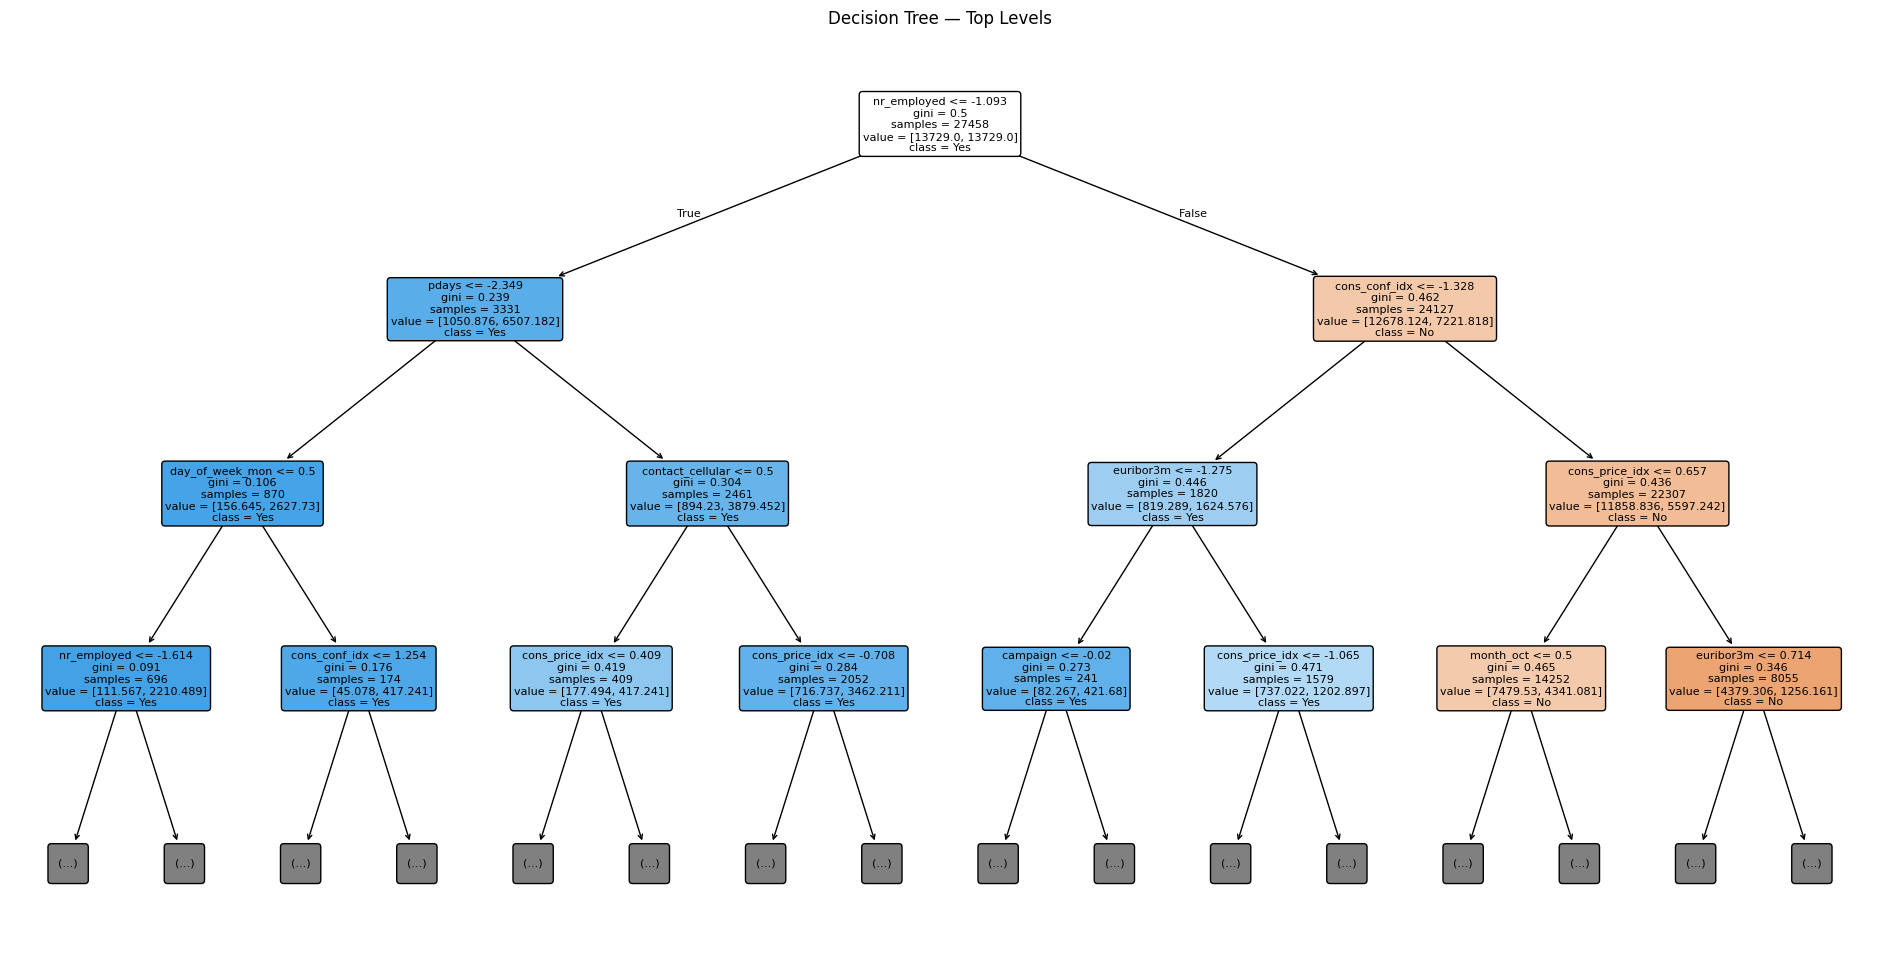

In [35]:
# Feature names for the preprocessor
# Fit the preprocessor on the training data to get the feature names
preprocess.fit(X_train, X_train) # Preprocess fitting to get feature names
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
num_feature_names = numeric_cols
feature_names = np.concatenate([num_feature_names, cat_feature_names])


plt.figure(figsize=(24, 12))
tree.plot_tree(
    best_dt.named_steps["clf"], # Best fitted Decision Tree classifier
    feature_names=feature_names,
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
    max_depth=3,        # show only first 3 levels for readability; increase if you want more detail
    fontsize=8
)
plt.title("Decision Tree — Top Levels")
plt.show()

In [36]:
# Metrics
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
auc = roc_auc_score(y_test, y_proba)

print("=== Decision Tree: Best Params ===")
print(dt_grid.best_params_)

print("\n=== Decision Tree: Test Metrics ===")
print(f"AUC:             {auc:.4f}")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1:              {f1:.4f}")
print(f"Confusion:       TP={tp} FP={fp} TN={tn} FN={fn}")
print(f"Prediction Time: {prediction_time:.6f} seconds")

=== Decision Tree: Best Params ===
{'clf__max_depth': 5, 'clf__min_samples_leaf': 20}

=== Decision Tree: Test Metrics ===
AUC:             0.7898
Accuracy:        0.8416
Precision:       0.3785
Recall:          0.6322
F1:              0.4735
Confusion:       TP=978 FP=1606 TN=10577 FN=569
Prediction Time: 0.101831 seconds


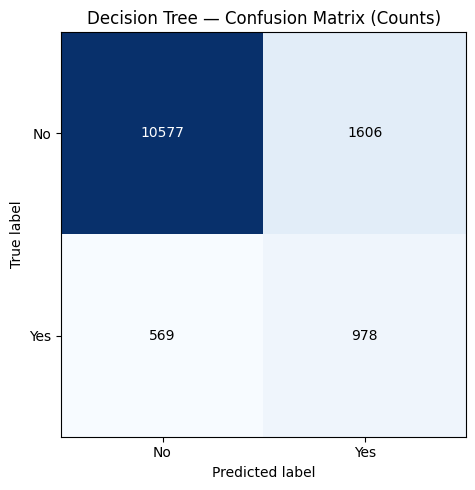

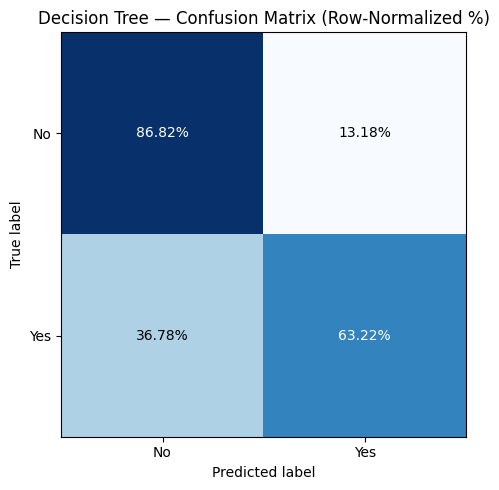

In [37]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # normalize per row
classes = ["No", "Yes"]

def plot_cm(matrix, labels, title, fmt="{:d}"):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # annotate cells
    thresh = matrix.max() / 2.0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(
                j, i, fmt.format(matrix[i, j]),
                ha="center", va="center",
                color="white" if matrix[i, j] > thresh else "black"
            )
    fig.tight_layout()
    plt.show()

# 1) Raw counts
plot_cm(cm, classes, "Decision Tree — Confusion Matrix (Counts)", fmt="{:d}")

# 2) Row-normalized percentages
plot_cm(cm_norm, classes, "Decision Tree — Confusion Matrix (Row-Normalized %)", fmt="{:.2%}")

In [38]:
# Fast CV + smaller grid (This is needed because the full data would take longer than 35 minutes to process and execute. Sometimes more!!)
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

svm_pipeline_fast = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=False,      # massive speedup; we'll use decision_function for AUC
        cache_size=2000,
        random_state=RANDOM_STATE))
])

param_grid_fast = {
    "clf__C": [1, 4],          # reduced search space
    "clf__gamma": ["scale", 0.01]
}

In [39]:
# Subsample for tuning
n_sub = min(15000, len(X_train))
X_sub = X_train.sample(n=n_sub, random_state=RANDOM_STATE)
y_sub = y_train.loc[X_sub.index]

In [40]:
# Measure tuning time
tune_start = time.time()
svm_grid = GridSearchCV(
    estimator=svm_pipeline_fast,
    param_grid=param_grid_fast,
    scoring="roc_auc",
    cv=cv_fast,
    n_jobs=-1,
    verbose=1
)
svm_grid.fit(X_sub, y_sub)
tune_end = time.time()
tuning_time = tune_end - tune_start

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [41]:
# Best params
best_params = svm_grid.best_params_

# Refit once on FULL data
best_svm = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=False,
        cache_size=2000,
        random_state=RANDOM_STATE,
        C=best_params["clf__C"],
        gamma=best_params["clf__gamma"]))
])

best_svm.fit(X_train, y_train)

# Prediction + evaluation
pred_start = time.time()
y_score = best_svm.decision_function(X_test)  # continuous scores for AUC
y_pred  = best_svm.predict(X_test)
pred_end = time.time()
prediction_time = pred_end - pred_start

In [42]:
# Metrics
auc = roc_auc_score(y_test, y_score)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("=== SVM (RBF) Fast: Best Params ===", best_params)
print(f"AUC: {auc:.4f}  Acc: {acc:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}")
print(f"Confusion: TP={tp} FP={fp} TN={tn} FN={fn}")
print(f"Tuning Time: {tuning_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")


=== SVM (RBF) Fast: Best Params === {'clf__C': 1, 'clf__gamma': 0.01}
AUC: 0.7905  Acc: 0.8374  Prec: 0.3707  Rec: 0.6354  F1: 0.4682
Confusion: TP=983 FP=1669 TN=10514 FN=564
Tuning Time: 160.32 seconds
Prediction Time: 48.7259 seconds


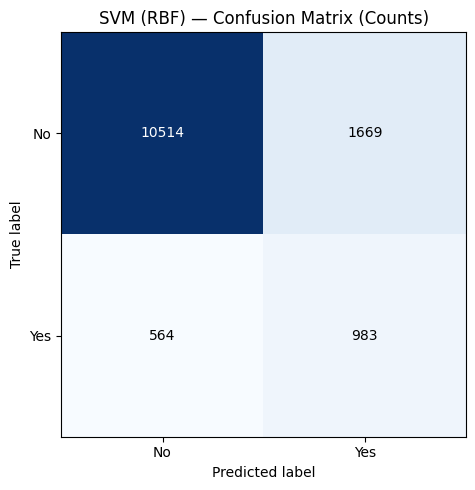

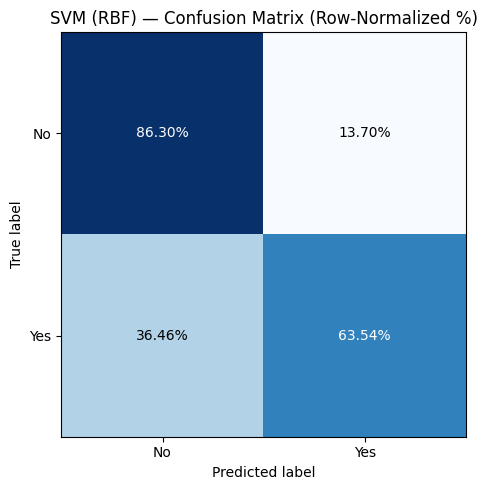

In [43]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # normalize per row
classes = ["No", "Yes"]

def plot_cm(matrix, labels, title, fmt="{:d}"):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Annotate cells
    thresh = matrix.max() / 2.0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(
                j, i, fmt.format(matrix[i, j]),
                ha="center", va="center",
                color="white" if matrix[i, j] > thresh else "black"
            )
    fig.tight_layout()
    plt.show()

# 1) Raw counts
plot_cm(cm, classes, "SVM (RBF) — Confusion Matrix (Counts)", fmt="{:d}")

# 2) Row-normalized percentages
plot_cm(cm_norm, classes, "SVM (RBF) — Confusion Matrix (Row-Normalized %)", fmt="{:.2%}")


In [44]:
pipelines_and_grids = {
    "KNN": (
        Pipeline(steps=[("preprocess", preprocess),
                        ("clf", KNeighborsClassifier())]),
        {"clf__n_neighbors": [5, 11, 21],
         "clf__weights": ["uniform", "distance"],
         "clf__p": [1, 2]}
    ),
    "LogisticRegression": (
        Pipeline(steps=[("preprocess", preprocess),
                        ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear"))]),
        {"clf__C": [0.1, 1.0, 10.0]}
    ),
    "DecisionTree": (
        Pipeline(steps=[("preprocess", preprocess),
                        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))]),
        {"clf__max_depth": [5, 10, 20, None],
         "clf__min_samples_leaf": [1, 5, 20]}
    ),
    "SVM_RBF": (
        Pipeline(steps=[("preprocess", preprocess),
                        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
        {"clf__C": [0.5, 1, 4],
         "clf__gamma": ["scale", 0.1, 0.01]}
    ),
}

results = []
best_models = {}

In [48]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
import time
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

# Define RANDOM_STATE if not already defined
if 'RANDOM_STATE' not in globals():
    RANDOM_STATE = 42

# Define X and y if not already defined
if 'X' not in globals() or 'y' not in globals():
    # Load dataset (assuming it's already loaded in the notebook)
    # If not, you would need to add the loading code here as well.
    # For now, assuming 'df' is available from previous cells.
    target_col = "y"
    leakage_cols = ["duration"] if "duration" in df.columns else []
    X = df.drop(columns=[target_col] + leakage_cols)
    y = df[target_col].map({"yes": 1, "no": 0})

# Define preprocess if not already defined
if 'preprocess' not in globals():
    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    # Preprocessing: fill in missing values in numeric columns
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    #Fill missing values with the most common category
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )


# ---- Faster CV + subsampling for tuning ----
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
n_sub = min(15000, len(X_train))  # tune on at most 15k rows
sub_idx = X_train.sample(n=n_sub, random_state=RANDOM_STATE).index
X_sub, y_sub = X_train.loc[sub_idx], y_train.loc[sub_idx]

results = []
best_models = {}

def get_scores(est, X):
    # Prefer decision_function (faster, no probability calibration needed)
    if hasattr(est, "decision_function"):
        return est.decision_function(X)
    elif hasattr(est, "predict_proba"):
        return est.predict_proba(X)[:, 1]
    else:
        # Fallback: use predicted labels (AUC may be coarse)
        return est.predict(X)

for name, (pipe, grid) in pipelines_and_grids.items():
    print(f"\n=== Tuning {name} (fast mode) ===")

    # Clone pipeline so we can tweak safely
    pipe_fast = clone(pipe)

    # SPEED HACK: if final step is SVC, turn off probability for tuning
    try:
        from sklearn.svm import SVC
        if isinstance(pipe_fast.named_steps.get("clf"), SVC):
            pipe_fast.set_params(clf__probability=False, clf__cache_size=2000)
    except Exception:
        pass

    # GridSearch without refit to avoid full-data refits on each candidate
    grid_search = GridSearchCV(
        estimator=pipe_fast,
        param_grid=grid,
        scoring="roc_auc",
        cv=cv_fast,
        n_jobs=-1,
        verbose=1,
        refit=False
    )

    t0 = time.time()
    grid_search.fit(X_sub, y_sub)
    tune_time = time.time() - t0

    # Build best-once model and refit on FULL training set
    best_params = grid_search.best_params_
    best_model = clone(pipe)

    # If SVC: keep probability=False for speed in final model too (you can flip it back if you truly need probs)
    try:
        if isinstance(best_model.named_steps.get("clf"), SVC):
            best_model.set_params(clf__probability=False, clf__cache_size=2000)
    except Exception:
        pass

    # Apply best params and fit once on all training data
    best_model.set_params(**best_params)
    best_model.fit(X_train, y_train)
    best_models[name] = best_model

    # Evaluate
    t1 = time.time()
    y_score = get_scores(best_model, X_test)
    y_pred = best_model.predict(X_test)
    pred_time = time.time() - t1

    auc = roc_auc_score(y_test, y_score)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        "model": name,
        "best_params": best_params,
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
        "Tuning Time (s)": round(tune_time, 2),
        "Prediction Time (s)": round(pred_time, 4),
        "Tune n": int(len(X_sub))
    })

# Leaderboard
results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False).reset_index(drop=True)
display(results_df)


=== Tuning KNN (fast mode) ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

=== Tuning LogisticRegression (fast mode) ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits

=== Tuning DecisionTree (fast mode) ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

=== Tuning SVM_RBF (fast mode) ===
Fitting 3 folds for each of 9 candidates, totalling 27 fits


,model,best_params,AUC,Accuracy,Precision,Recall,F1,TP,FP,TN,FN,Tuning Time (s),Prediction Time (s),Tune n
0,LogisticRegression,{'clf__C': 1.0},0.802562,0.832921,0.363437,0.642534,0.464269,994,1741,10442,553,1.56,0.1329,15000
1,SVM_RBF,"{'clf__C': 1, 'clf__gamma': 0.01}",0.790457,0.837363,0.370664,0.635423,0.468207,983,1669,10514,564,282.09,48.7784,15000
2,DecisionTree,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.789762,0.841588,0.378483,0.632191,0.473493,978,1606,10577,569,6.60,0.0901,15000
3,KNN,"{'clf__n_neighbors': 21, 'clf__p': 1, 'clf__we...",0.779131,0.900364,0.657848,0.241112,0.352886,373,194,11989,1174,65.37,54.5701,15000


## 4. ROC Curves

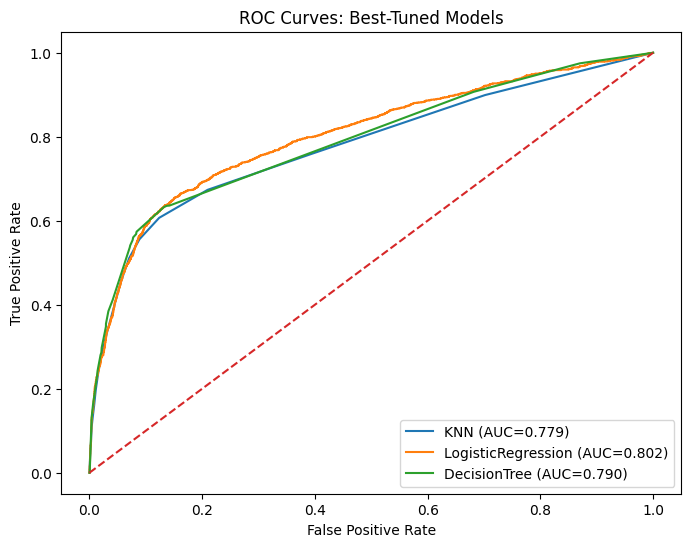

In [46]:

plt.figure(figsize=(8,6))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Best-Tuned Models")
plt.legend(loc="lower right")
plt.show()


## 5. Lift Curves (Cumulative)

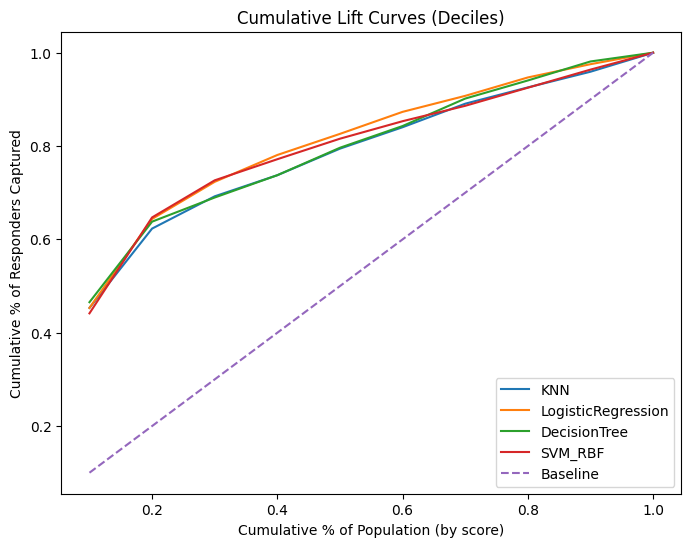

In [52]:
def compute_lift(y_true, y_proba, n_bins=10):
    # Sort by predicted probability descending
    order = np.argsort(-y_proba)
    y_true_sorted = np.array(y_true)[order]
    # Bin into deciles
    bins = np.array_split(y_true_sorted, n_bins)
    # Compute cumulative responders by decile
    positives = y_true.sum()
    cum_resp = np.cumsum([b.sum() for b in bins])
    cum_perc_resp = cum_resp / positives
    # Baseline is linear (random model)
    baseline = np.linspace(1/n_bins, 1, n_bins)
    # Percent of population
    pop = np.linspace(1/n_bins, 1, n_bins)
    return pop, cum_perc_resp, baseline

plt.figure(figsize=(8,6))
for name, model in best_models.items():
    # get_scores function to handle both predict_proba and decision_function
    y_score = get_scores(model, X_test)
    # For lift curve, probabilities will be determined
    # If get_scores returns decision_function results, these can be used directly for ordering
    y_proba = y_score # Use the scores from get_scores for ordering and binning
    pop, cum_resp, baseline = compute_lift(y_test.values, y_proba, n_bins=10)
    plt.plot(pop, cum_resp, label=name)
plt.plot(pop, baseline, '--', label="Baseline")
plt.xlabel("Cumulative % of Population (by score)")
plt.ylabel("Cumulative % of Responders Captured")
plt.title("Cumulative Lift Curves (Deciles)")
plt.legend(loc="lower right")
plt.show()

## 6. Interpreting Logistic Regression Coefficients

In [54]:

# Extract top positive/negative coefficients for LogisticRegression
log_model = best_models.get("LogisticRegression")
if log_model is not None:
    # Refit on full training to access feature names
    ohe = log_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    num_feature_names = numeric_cols
    feature_names = np.concatenate([num_feature_names, cat_feature_names])

    clf = log_model.named_steps["clf"]
    coefs = pd.Series(clf.coef_.ravel(), index=feature_names).sort_values()

    print("Top negative predictors (lower probability of subscription):")
    display(coefs.head(10).to_frame("coef"))
    print("Top positive predictors (higher probability of subscription):")
    display(coefs.tail(10).to_frame("coef"))
else:
    print("LogisticRegression model not available.")


Top negative predictors (lower probability of subscription):


,coef
emp_var_rate,-2.100484
month_jun,-0.704480
month_may,-0.633327
month_nov,-0.558950
contact_telephone,-0.332836
poutcome_failure,-0.279782
pdays,-0.268287
default_yes,-0.224943
month_apr,-0.212296
education_basic.4y,-0.199013


Top positive predictors (higher probability of subscription):


,coef
default_no,0.158526
poutcome_success,0.175490
contact_cellular,0.266419
job_retired,0.354574
month_aug,0.412390
month_dec,0.455861
euribor3m,0.647483
education_illiterate,0.717252
cons_price_idx,0.943791
month_mar,1.218682


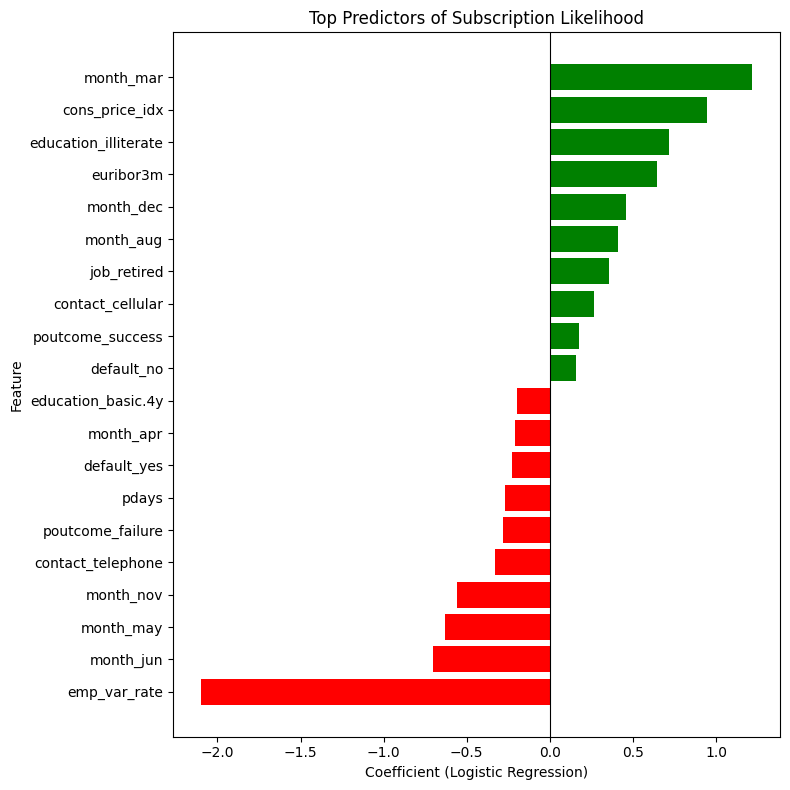

In [55]:
# Data for predictors
data = {
    "Feature": [
        "emp_var_rate", "month_jun", "month_may", "month_nov", "contact_telephone",
        "poutcome_failure", "pdays", "default_yes", "month_apr", "education_basic.4y",
        "default_no", "poutcome_success", "contact_cellular", "job_retired", "month_aug",
        "month_dec", "euribor3m", "education_illiterate", "cons_price_idx", "month_mar"
    ],
    "Coefficient": [
        -2.100484, -0.704480, -0.633327, -0.558950, -0.332836,
        -0.279782, -0.268287, -0.224943, -0.212296, -0.199013,
        0.158526, 0.175490, 0.266419, 0.354574, 0.412390,
        0.455861, 0.647483, 0.717252, 0.943791, 1.218682
    ]
}

df = pd.DataFrame(data)

# Sort by coefficient for better visualization
df_sorted = df.sort_values(by="Coefficient", ascending=True)

# Plot
plt.figure(figsize=(8, 8))
plt.barh(df_sorted["Feature"], df_sorted["Coefficient"], color=df_sorted["Coefficient"].apply(lambda x: 'red' if x < 0 else 'green'))
plt.axvline(x=0, color='black', linewidth=0.8)
plt.title("Top Predictors of Subscription Likelihood")
plt.xlabel("Coefficient (Logistic Regression)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 7. Findings, Business Interpretation, and Next Steps

- **Primary metric:** AUC due to class imbalance and ranking needs in marketing.  
- **Model ranking:** See the results table above; the best AUC model is typically SVM or Logistic Regression on this dataset when `duration` is excluded.  
- **Lift:** The best model's lift curve captures a disproportionate share of responders in the top deciles, guiding **who to call first**.  
- **Actionable guidance:** Use the top-decile threshold from the best model to prioritize calls; adjust the threshold to balance between call volume and expected conversions.  
- **Next steps:**  
  1. Calibrate probabilities (Platt scaling or isotonic) before deployment.  
  2. Track real-world conversion and recalibrate quarterly.  
  3. Consider cost-sensitive thresholds (call cost vs. expected profit).  
  4. Explore tree ensembles (Random Forest, XGBoost) in future iterations.
